In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
#     data_list = [train_sst,train_t300,train_ua,train_va]
#     train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
#     data_list = [train_sst2,train_t3002,train_ua2,train_va2]
#     train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Train samples: 4645, Valid samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(24):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(loss_epoch)),loss_epoch)
        plt.tight_layout()
        plt.show()
        

In [101]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        
        self.batch_norm = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True)
#         self.lstm = nn.LSTM(input_size = 1540 * 4, hidden_size = 256, num_layers=2, batch_first=True, bidirectional=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 64))
        self.linear = nn.Linear(64, 24)

    def forward(self, sst, t300, ua, va):
        sst = self.conv1(sst)  # batch * 12 * (24 - 2) * (72 -2)
        t300 = self.conv2(t300)
        ua = self.conv3(ua)
        va = self.conv4(va)

        sst = torch.flatten(sst, start_dim=2)  # batch * 12 * 1540
        t300 = torch.flatten(t300, start_dim=2)
        ua = torch.flatten(ua, start_dim=2)
        va = torch.flatten(va, start_dim=2)  
        
        x = torch.cat([sst, t300, ua, va], dim=-1) # batch * 12 * (1540 * 4)
#         x = torch.flatten(x, start_dim=1)
#         x, (h_n, c_n) = self.lstm(x)
#         x = x[:,-1]
        x = self.avgpool(x).squeeze(dim=-2)
        x = self.linear(x)
        return x

In [102]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [103]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 0.020064M


In [104]:
model

CNN_Model(
  (conv1): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv4): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (batch_norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 64))
  (linear): Linear(in_features=64, out_features=24, bias=True)
)

acskill_socre:5.660566379789698, rmse_score:18.5755831598206
Epoch: 0, Valid Score: -12.915016780030902

Step: 0, Train Loss: 0.734809398651123
Step: 20, Train Loss: 0.8023366332054138
Step: 40, Train Loss: 0.5901749134063721
Step: 60, Train Loss: 0.6177441477775574
Step: 80, Train Loss: 0.7865614295005798
Step: 100, Train Loss: 0.7180470824241638
Step: 120, Train Loss: 0.7907853126525879
Step: 140, Train Loss: 0.5303407311439514
Epoch: 1, Train loss: 0.7196096192075782
acskill_socre:2.7218806695873945, rmse_score:18.672434177995008
Epoch: 1, Valid Score: -15.950553508407614
Model saved successfully


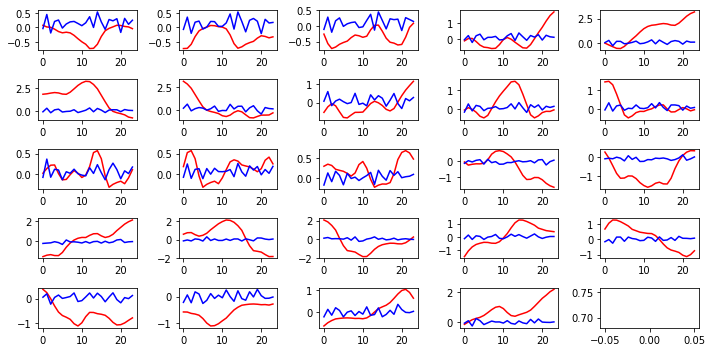

Step: 0, Train Loss: 0.7236179709434509
Step: 20, Train Loss: 0.6269601583480835
Step: 40, Train Loss: 0.8160244226455688
Step: 60, Train Loss: 0.7310287356376648
Step: 80, Train Loss: 0.7980197668075562
Step: 100, Train Loss: 0.6946364641189575
Step: 120, Train Loss: 0.7306758761405945
Step: 140, Train Loss: 0.6538226008415222
Epoch: 2, Train loss: 0.6637395628511089
acskill_socre:6.9753214583144025, rmse_score:18.62460443162449
Epoch: 2, Valid Score: -11.649282973310088
Model saved successfully


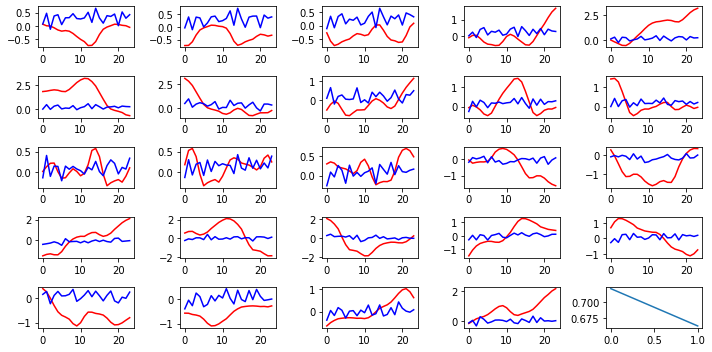

Step: 0, Train Loss: 0.5186768770217896
Step: 20, Train Loss: 0.6061981320381165
Step: 40, Train Loss: 0.6779639720916748
Step: 60, Train Loss: 0.6108552813529968
Step: 80, Train Loss: 0.5854736566543579
Step: 100, Train Loss: 0.6372334957122803
Step: 120, Train Loss: 0.5080889463424683
Step: 140, Train Loss: 0.77182936668396
Epoch: 3, Train loss: 0.6198005582371803
acskill_socre:11.368849563530919, rmse_score:18.3480458340492
Epoch: 3, Valid Score: -6.97919627051828
Model saved successfully


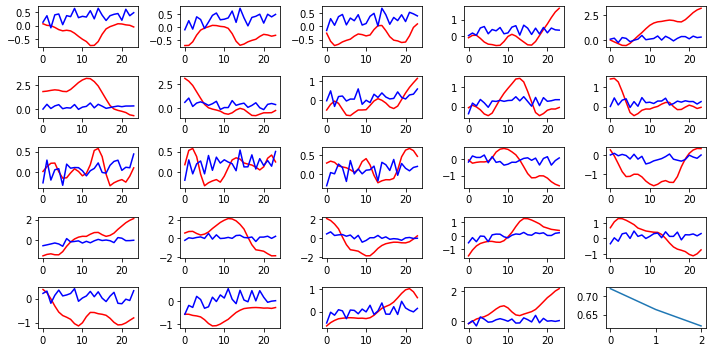

Step: 0, Train Loss: 0.595072865486145
Step: 20, Train Loss: 0.5534305572509766
Step: 40, Train Loss: 0.662959635257721
Step: 60, Train Loss: 0.577821671962738
Step: 80, Train Loss: 0.8409885168075562
Step: 100, Train Loss: 0.5691629648208618
Step: 120, Train Loss: 0.5543785095214844
Step: 140, Train Loss: 0.5821427702903748
Epoch: 4, Train loss: 0.5958474741814888
acskill_socre:13.86495713351097, rmse_score:18.22927914354213
Epoch: 4, Valid Score: -4.3643220100311595
Model saved successfully


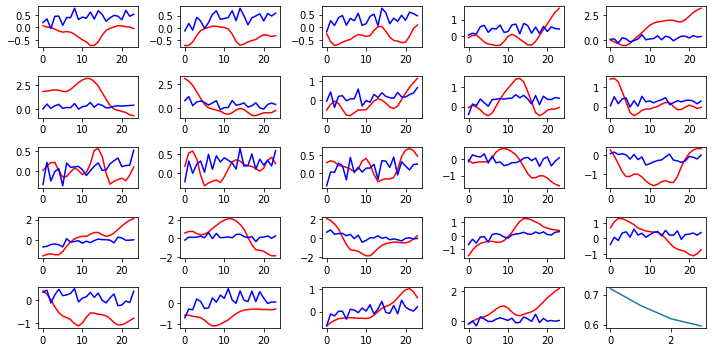

Step: 0, Train Loss: 0.6719813346862793
Step: 20, Train Loss: 0.5839882493019104
Step: 40, Train Loss: 0.47594714164733887
Step: 60, Train Loss: 0.6734455823898315
Step: 80, Train Loss: 0.5460277795791626
Step: 100, Train Loss: 0.5465058088302612
Step: 120, Train Loss: 0.4143310785293579
Step: 140, Train Loss: 0.48376697301864624
Epoch: 5, Train loss: 0.5775343669603948
acskill_socre:15.858287114344954, rmse_score:18.039996997497898
Epoch: 5, Valid Score: -2.1817098831529442
Model saved successfully


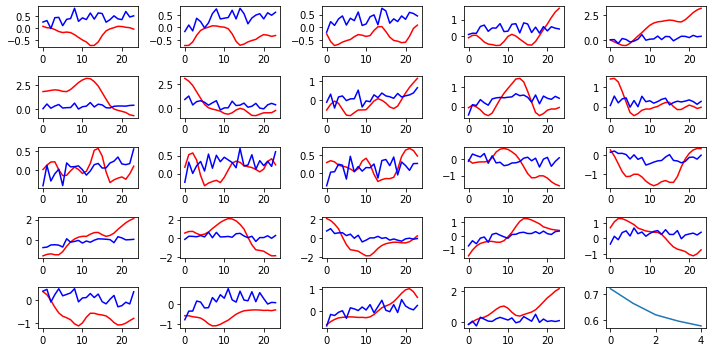

Step: 0, Train Loss: 0.620424211025238
Step: 20, Train Loss: 0.6015936136245728
Step: 40, Train Loss: 0.48464497923851013
Step: 60, Train Loss: 0.46627920866012573
Step: 80, Train Loss: 0.5860943794250488
Step: 100, Train Loss: 0.48664888739585876
Step: 120, Train Loss: 0.6470670104026794
Step: 140, Train Loss: 0.5318433046340942
Epoch: 6, Train loss: 0.5630025649315691
acskill_socre:16.80165918142945, rmse_score:18.019297822735762
Epoch: 6, Valid Score: -1.217638641306312
Model saved successfully


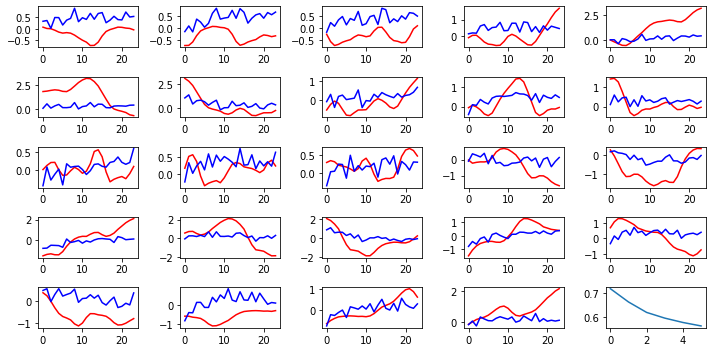

Step: 0, Train Loss: 0.6318625807762146
Step: 20, Train Loss: 0.6696581840515137
Step: 40, Train Loss: 0.4492301940917969
Step: 60, Train Loss: 0.4654734134674072
Step: 80, Train Loss: 0.4065057635307312
Step: 100, Train Loss: 0.6809872388839722
Step: 120, Train Loss: 0.6219889521598816
Step: 140, Train Loss: 0.44864127039909363
Epoch: 7, Train loss: 0.5523185089026412
acskill_socre:18.36895359310798, rmse_score:17.839620374414192
Epoch: 7, Valid Score: 0.5293332186937896
Model saved successfully


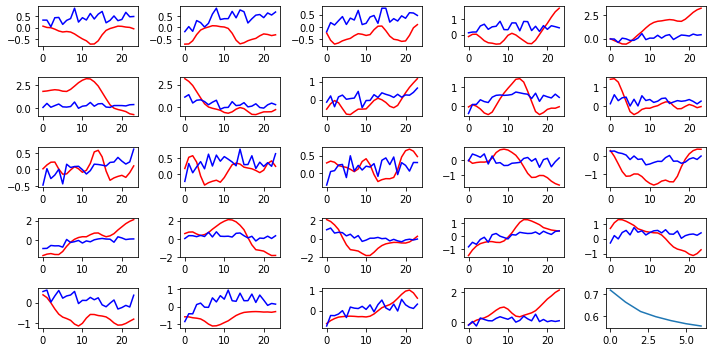

Step: 0, Train Loss: 0.5119632482528687
Step: 20, Train Loss: 0.49001631140708923
Step: 40, Train Loss: 0.5420362949371338
Step: 60, Train Loss: 0.5613670349121094
Step: 80, Train Loss: 0.5524634122848511
Step: 100, Train Loss: 0.5626856684684753
Step: 120, Train Loss: 0.910858154296875
Step: 140, Train Loss: 0.38503044843673706
Epoch: 8, Train loss: 0.5441029126921745
acskill_socre:19.15191078007011, rmse_score:17.787527799192894
Epoch: 8, Valid Score: 1.3643829808772168
Model saved successfully


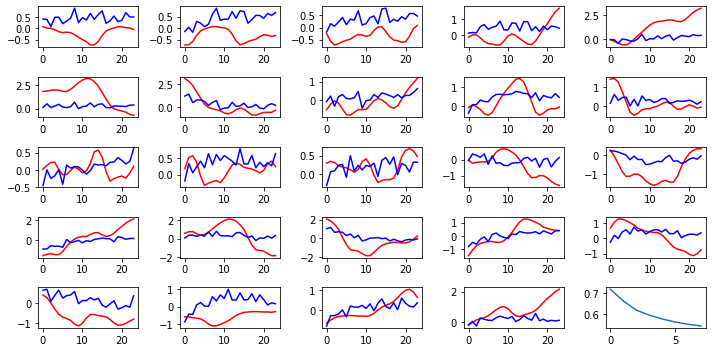

Step: 0, Train Loss: 0.46884632110595703
Step: 20, Train Loss: 0.6257035136222839
Step: 40, Train Loss: 0.5486421585083008
Step: 60, Train Loss: 0.46807536482810974
Step: 80, Train Loss: 0.5797524452209473
Step: 100, Train Loss: 0.6837475299835205
Step: 120, Train Loss: 0.5377625823020935
Step: 140, Train Loss: 0.520750105381012
Epoch: 9, Train loss: 0.5363548908331622
acskill_socre:19.744415170969983, rmse_score:17.7484180341893
Epoch: 9, Valid Score: 1.9959971367806837
Model saved successfully


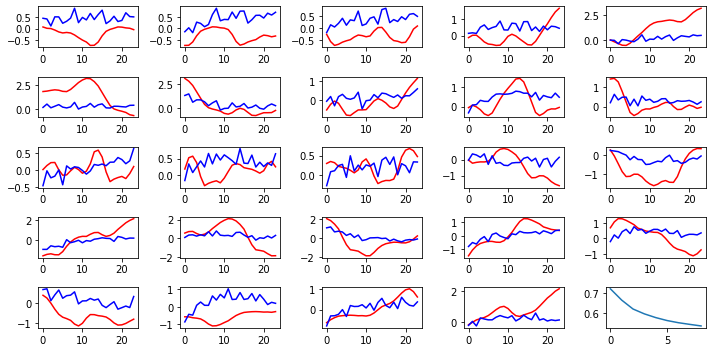

Step: 0, Train Loss: 0.5752773284912109
Step: 20, Train Loss: 0.4842500686645508
Step: 40, Train Loss: 0.7389736175537109
Step: 60, Train Loss: 0.8874887228012085
Step: 80, Train Loss: 0.407282292842865
Step: 100, Train Loss: 0.49343404173851013
Step: 120, Train Loss: 0.3539730906486511
Step: 140, Train Loss: 0.5251482725143433
Epoch: 10, Train loss: 0.5312923344030772
acskill_socre:20.635552353519408, rmse_score:17.630530276481654
Epoch: 10, Valid Score: 3.0050220770377543
Model saved successfully


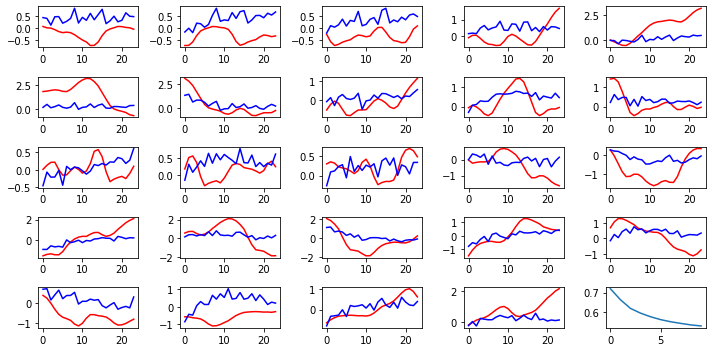

Step: 0, Train Loss: 0.6940057277679443
Step: 20, Train Loss: 0.5770382285118103
Step: 40, Train Loss: 0.5391229391098022
Step: 60, Train Loss: 0.40866249799728394
Step: 80, Train Loss: 0.5908640623092651
Step: 100, Train Loss: 0.49648556113243103
Step: 120, Train Loss: 0.4822443425655365
Step: 140, Train Loss: 0.5568664073944092
Epoch: 11, Train loss: 0.5256460886703779
acskill_socre:21.045308031492453, rmse_score:17.60187410533696
Epoch: 11, Valid Score: 3.4434339261554925
Model saved successfully


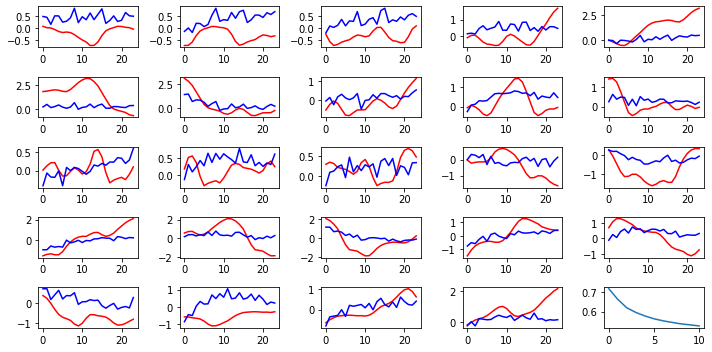

Step: 0, Train Loss: 0.3568750321865082
Step: 20, Train Loss: 0.4953145682811737
Step: 40, Train Loss: 0.47224220633506775
Step: 60, Train Loss: 0.3990834653377533
Step: 80, Train Loss: 0.5486376285552979
Step: 100, Train Loss: 0.5733753442764282
Step: 120, Train Loss: 0.5266473889350891
Step: 140, Train Loss: 0.4179437756538391
Epoch: 12, Train loss: 0.5241169758038978
acskill_socre:21.581402881396144, rmse_score:17.538167253584145
Epoch: 12, Valid Score: 4.043235627811999
Model saved successfully


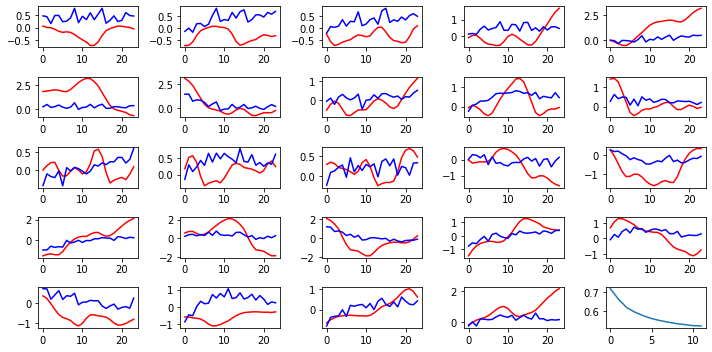

Step: 0, Train Loss: 0.5231548547744751
Step: 20, Train Loss: 0.6206650733947754
Step: 40, Train Loss: 0.5486370921134949
Step: 60, Train Loss: 0.5601445436477661
Step: 80, Train Loss: 0.5087239146232605
Step: 100, Train Loss: 0.40198907256126404
Step: 120, Train Loss: 0.35670241713523865
Step: 140, Train Loss: 0.5529763698577881
Epoch: 13, Train loss: 0.5208166633566765
acskill_socre:21.835337869080448, rmse_score:17.53220491812015
Epoch: 13, Valid Score: 4.303132950960297
Model saved successfully


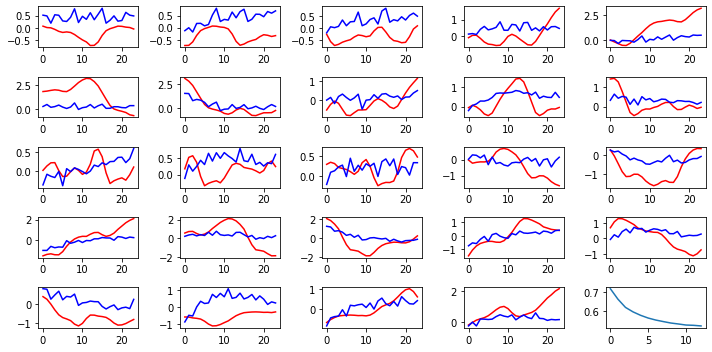

Step: 0, Train Loss: 0.41423630714416504
Step: 20, Train Loss: 0.6266146898269653
Step: 40, Train Loss: 0.42503437399864197
Step: 60, Train Loss: 0.41495081782341003
Step: 80, Train Loss: 0.5976650714874268
Step: 100, Train Loss: 0.6359469890594482
Step: 120, Train Loss: 0.444063276052475
Step: 140, Train Loss: 0.5006275773048401
Epoch: 14, Train loss: 0.5164529107613106
acskill_socre:22.222590642432316, rmse_score:17.488331323372943
Epoch: 14, Valid Score: 4.7342593190593725
Model saved successfully


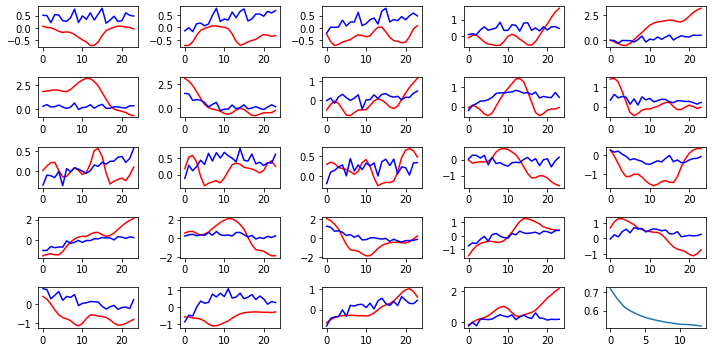

Step: 0, Train Loss: 0.42309993505477905
Step: 20, Train Loss: 0.5889574289321899
Step: 40, Train Loss: 0.5525026321411133
Step: 60, Train Loss: 0.4942547678947449
Step: 80, Train Loss: 0.512880802154541
Step: 100, Train Loss: 0.7196316719055176
Step: 120, Train Loss: 0.30587565898895264
Step: 140, Train Loss: 0.3834836483001709
Epoch: 15, Train loss: 0.5132018386909406
acskill_socre:22.385208280661494, rmse_score:17.495482642377414
Epoch: 15, Valid Score: 4.88972563828408
Model saved successfully


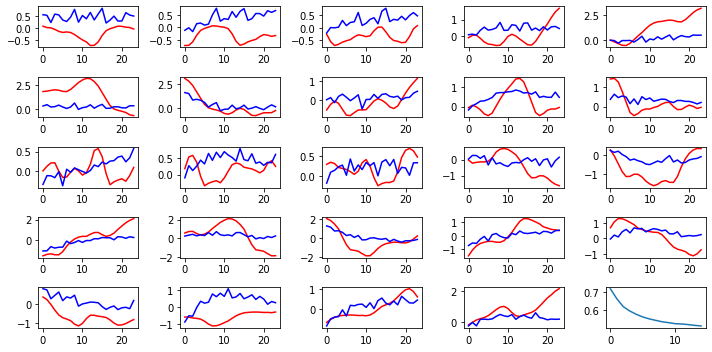

Step: 0, Train Loss: 0.39375969767570496
Step: 20, Train Loss: 0.39892813563346863
Step: 40, Train Loss: 0.6322019100189209
Step: 60, Train Loss: 0.6112386584281921
Step: 80, Train Loss: 0.7113814353942871
Step: 100, Train Loss: 0.33887314796447754
Step: 120, Train Loss: 0.657713770866394
Step: 140, Train Loss: 0.5064696073532104
Epoch: 16, Train loss: 0.5120926468747936
acskill_socre:23.094747252324243, rmse_score:17.380036470818627
Epoch: 16, Valid Score: 5.714710781505616
Model saved successfully


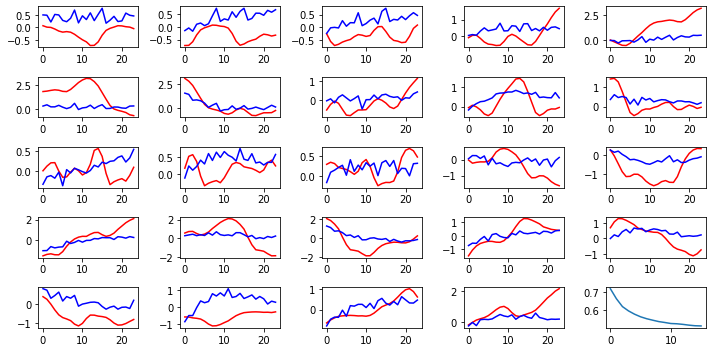

Step: 0, Train Loss: 0.4276238679885864
Step: 20, Train Loss: 0.5654555559158325
Step: 40, Train Loss: 0.6766301989555359
Step: 60, Train Loss: 0.5338605046272278
Step: 80, Train Loss: 0.4601449966430664
Step: 100, Train Loss: 0.4212273061275482
Step: 120, Train Loss: 0.5756798386573792
Step: 140, Train Loss: 0.41852304339408875
Epoch: 17, Train loss: 0.5092217528248486
acskill_socre:23.213801883230026, rmse_score:17.37253467888257
Epoch: 17, Valid Score: 5.8412672043474565
Model saved successfully


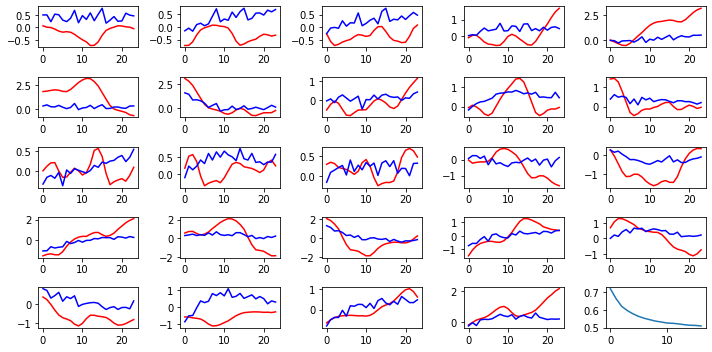

Step: 0, Train Loss: 0.6797866821289062
Step: 20, Train Loss: 0.6516780853271484
Step: 40, Train Loss: 0.5324956178665161
Step: 60, Train Loss: 0.6005060076713562
Step: 80, Train Loss: 0.4983672499656677
Step: 100, Train Loss: 0.7004348635673523
Step: 120, Train Loss: 0.6712624430656433
Step: 140, Train Loss: 0.4449625015258789
Epoch: 18, Train loss: 0.5051891820071495
acskill_socre:23.60668169969178, rmse_score:17.31797454822038
Epoch: 18, Valid Score: 6.2887071514713995
Model saved successfully


In [ ]:
train(num_epochs=50)

In [ ]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [16]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [17]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [18]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [19]:
make_zip()